In [3]:
#Load in data from matlab mat file and put it in a pandas array
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
data = sio.loadmat('c_yperformance.mat')
x_values = sio.loadmat('xaxis.mat')
performance = data['C_YPerformance']
x_axis_array = x_values['C_XaxisRSIplot']
#Remove duplicate rows from this array
x_axis = x_axis_array[1]

In [12]:
#Transform probabilities back into counts for "number of successes". This is not my data, and I don't have access to the original source so I am estimating some of it (only for the hypothesis figure)
#In this dataset, trials types occured at different rates. The first and last column (RSI 1 and RSI 0) occured most often. The middle columns each had 80 trials out of a total 1500; I am estimating 500 each for the 1 and 0 positions. 
performance[:,0] = performance[:,0]*500
performance[:,1:6] = performance[:,1:6]*80
performance[:,6] = performance [:,6]*500

performance_fall = performance[0:7,:]
performance_spring = performance[8:11,:]

In [13]:
fall_performance_sum = np.sum(performance_fall,0)
spring_performance_sum = np.sum(performance_spring,0)
fall_total_trials = [3500,560,560,560,560,560,3500]
spring_total_trials = [1500,240,240,240,240,240,1500]

In [15]:
spring_performance_sum

array([7.16293872e+05, 1.08529101e+04, 8.17303704e+03, 2.61771337e+03,
       9.50179894e+02, 4.57142857e+02, 8.77946405e+03])

In [16]:
fall_performance_sum

array([1678621.10192971,   19482.31962163,   10019.54177821,
          7452.95994328,    2971.44747725,    3549.17201449,
         24406.09394605])

In [17]:
import astropy.stats as aps

In [9]:
spring_CIs = aps.binom_conf_interval(spring_performance_sum,spring_total_trials,.95,'wilson')
fall_CIs = aps.binom_conf_interval(fall_performance_sum,fall_total_trials,.95,'wilson')

In [10]:
fall_CIs

array([[0.95206549, 0.39346767, 0.19067821, 0.13754516, 0.048312  ,
        0.05904861, 0.01035978],
       [0.96521345, 0.47528977, 0.25952185, 0.19914781, 0.08974357,
        0.10383664, 0.01813507]])

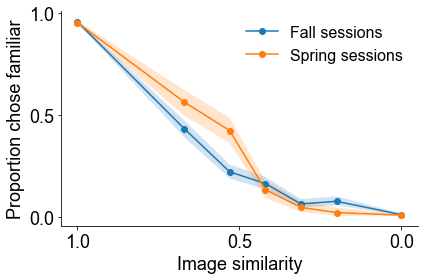

In [11]:
hfont = {'fontname':'Arial'}
font = fm.FontProperties(family='Arial',
                                   weight='normal',
                                   style='normal', size=16)

ax = plt.subplot(111)
ax.plot(x_axis,fall_performance_sum/fall_total_trials,marker='o')
ax.plot(x_axis,spring_performance_sum/spring_total_trials,marker='o')
plt.fill_between(x_axis,fall_CIs[0],fall_CIs[1],alpha=.2)
plt.fill_between(x_axis,spring_CIs[0],spring_CIs[1],alpha=.2)
plt.legend(['Fall sessions','Spring sessions'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('hypothesis_plot.pdf')


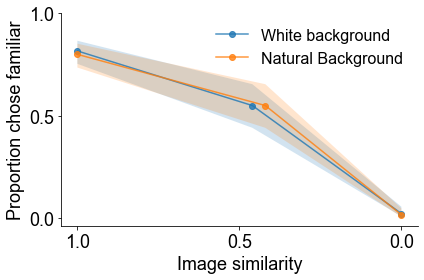

In [92]:
wbx_x = np.array([0,.46,1])
wbx_x_jittered = np.array([0,.42,1])

nb_nb_success = np.array([4,44,147])
nb_wb_success = np.array([3,44,144])

nb_total_trials = np.array([180,80,180])

nb_nb_CIs = aps.binom_conf_interval(nb_nb_success,nb_total_trials,.95,'wilson')
nb_wb_CIs = aps.binom_conf_interval(nb_wb_success,nb_total_trials,.95,'wilson')

ax2 = plt.subplot(111)
ax2.plot(wbx_x,nb_nb_success/nb_total_trials,marker='o',alpha=.8)
ax2.plot(wbx_x_jittered,nb_wb_success/nb_total_trials,marker='o',alpha=.8)
plt.fill_between(wbx_x,nb_nb_CIs[0],nb_nb_CIs[1],alpha=.2)
plt.fill_between(wbx_x_jittered,nb_wb_CIs[0],nb_wb_CIs[1],alpha=.2)
plt.legend(['White background','Natural Background'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('results_plot.pdf')




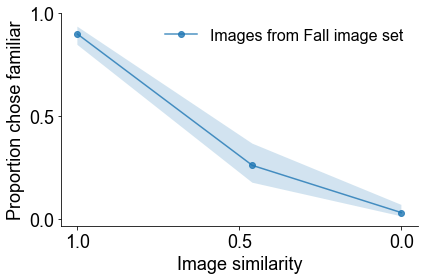

In [98]:
wbx_x = np.array([0,.46,1])
wbx_x_jittered = np.array([0,.42,1])

nb_nb_success = np.array([6,21,162])

nb_total_trials = np.array([180,80,180])

nb_nb_CIs = aps.binom_conf_interval(nb_nb_success,nb_total_trials,.95,'wilson')
nb_wb_CIs = aps.binom_conf_interval(nb_wb_success,nb_total_trials,.95,'wilson')

ax3 = plt.subplot(111)
ax3.plot(wbx_x,nb_nb_success/nb_total_trials,marker='o',alpha=.8)
plt.fill_between(wbx_x,nb_nb_CIs[0],nb_nb_CIs[1],alpha=.2)
plt.legend(['Images from Fall image set'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('alzheimers_plot.pdf')

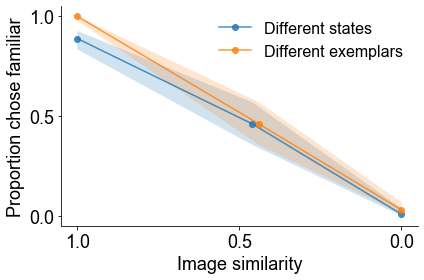

In [107]:
wbx_x = np.array([0,.46,1])
wbx_x_jittered = np.array([0,.44,1])

nb_nb_success = np.array([2,37,160])
nb_wb_success = np.array([6,37,180])

nb_total_trials = np.array([180,80,180])

nb_nb_CIs = aps.binom_conf_interval(nb_nb_success,nb_total_trials,.95,'wilson')
nb_wb_CIs = aps.binom_conf_interval(nb_wb_success,nb_total_trials,.95,'wilson')

ax2 = plt.subplot(111)
ax2.plot(wbx_x,nb_nb_success/nb_total_trials,marker='o',alpha=.8)
ax2.plot(wbx_x_jittered,nb_wb_success/nb_total_trials,marker='o',alpha=.8)
plt.fill_between(wbx_x,nb_nb_CIs[0],nb_nb_CIs[1],alpha=.2)
plt.fill_between(wbx_x_jittered,nb_wb_CIs[0],nb_wb_CIs[1],alpha=.2)
plt.legend(['Different states','Different exemplars'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('results_plot_states.pdf')
